# Определение возраста покупателей

**Описание проекта:**  
Внедрение системы компьютерного зрения для обработки фотографий, полученных при фотофиксации в прикассовой зоне, с целью определять возраст клиентов, что позволит:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Задача:**  
Построить модель, которая по фотографии определит приблизительный возраст человека. 

**Данные:**  
Датасет с фотографиями людей и указанием их реального возраста. Данные взяты с сайта [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-и-знакомство-с-данными" data-toc-modified-id="Загрузка-и-знакомство-с-данными-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и знакомство с данными</a></span></li><li><span><a href="#Моделирование-и-обучение" data-toc-modified-id="Моделирование-и-обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Моделирование и обучение</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Импорт библиотек

In [2]:
# фиксируем сиды, чтобы добиться воспроизводимости (но не исключаем влияние GPU)

# Seed value
random_state = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(random_state)

# disable GPU
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(random_state)

# 3. Set `numpy` pseudo-random generator at a fixed value + для метода fit
import numpy as np
np.random.seed(random_state)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(random_state)
# for later versions: 
tf.compat.v1.set_random_seed(random_state)

# # 5. Configure a new global `tensorflow` session
# from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# # for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# динамическая загрузка данных
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.models import load_model

from tensorflow.keras.applications.resnet import ResNet50

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Загрузка и знакомство с данными

В нашем распоряжении данные, взятые с сайта ChaLearn Looking at People:
- Папка со всеми изображениями `final_files` - будем использовать динамическую загрузку данных
- CSV-файл `labels.csv` с двумя колонками: file_name и real_age 



In [5]:
# функция динамической загрузки полного датасета
def load_full_dataset(path):
    # загрузка таблицы
    labels = pd.read_csv(path + 'labels.csv')
    # загрузка изображение
    datagen = ImageDataGenerator(rescale=1./255)
    datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=random_state) 
    return labels, datagen_flow

In [6]:
# возможные пути расположения файла
server_path = '/datasets/faces/'  
local_path = 'datasets/'
colab_path = '/content/final_files'

# проверка, какой путь существует
if os.path.exists(server_path):
    path = server_path
    print('server_path')
elif os.path.exists(local_path):
    path = ''
    print('local_path')
elif os.path.exists(colab_path):
    path = colab_path
    print('colab_path')
else:
    print('Неправильно указан путь к файлу')

local_path


In [7]:
# загружаем датасет
labels, datagen_flow = load_full_dataset(path)

Found 7591 validated image filenames.


In [8]:
# оценим содержимое таблицы
display(labels.head(), (labels.info()))
# проверим дубликаты
print(f'\nДубликаты: {labels.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


None


Дубликаты: 0


Датасет содержит 7591 фотографию людей с указанием их реального возраста.  
Пропуски и дубликаты отсутствуют. 

Оценим распределение целевого признака

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

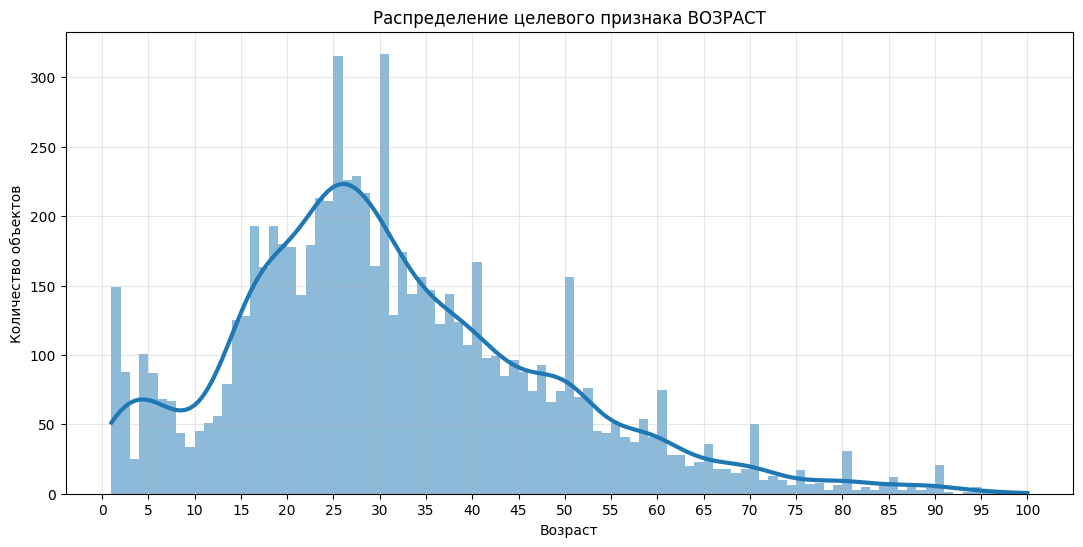

In [9]:
# распределение возраста в выборке
plt.figure(figsize=(13,6))
sns.histplot(labels['real_age'], binwidth=1, kde=True, edgecolor=None, line_kws={'linewidth': 3})
plt.title('Распределение целевого признака ВОЗРАСТ')
plt.xlabel('Возраст')
plt.ylabel('Количество объектов')
plt.xticks(range(0, 101, 5))
plt.grid(alpha=0.3)
labels['real_age'].describe()

- Возраст людей на фотографиях датасета в диапазоне от 1 до 100 лет
- Возраста в выборке представлены неравномерно. Наиболее представительные возраста (более 100 фотографий на каждый) в диапазогне 15 - 40 
- Наблюдаются пики в округлённых возрастах 25, 30, 40, 50 и т.д. и 1 год. Это может демонстрировать, что часть данных была размечена вручную людьми, а не является реальной информацией о возрасте человека. Из статьи авторов датасета: *Дополнительные изображения из Интернета были загружены на Amazon Mechanical Turk (AMT) и были помечены многими пользователями (рабочими), обеспечивая минимум 30 голосов на изображение.* Также известно, что сбор основной части фотографий проводился случайными пользователями приложения, которые также могли указывать недостоверную информацию. 

Посмотрим что представляют собой фотографии в датасете.

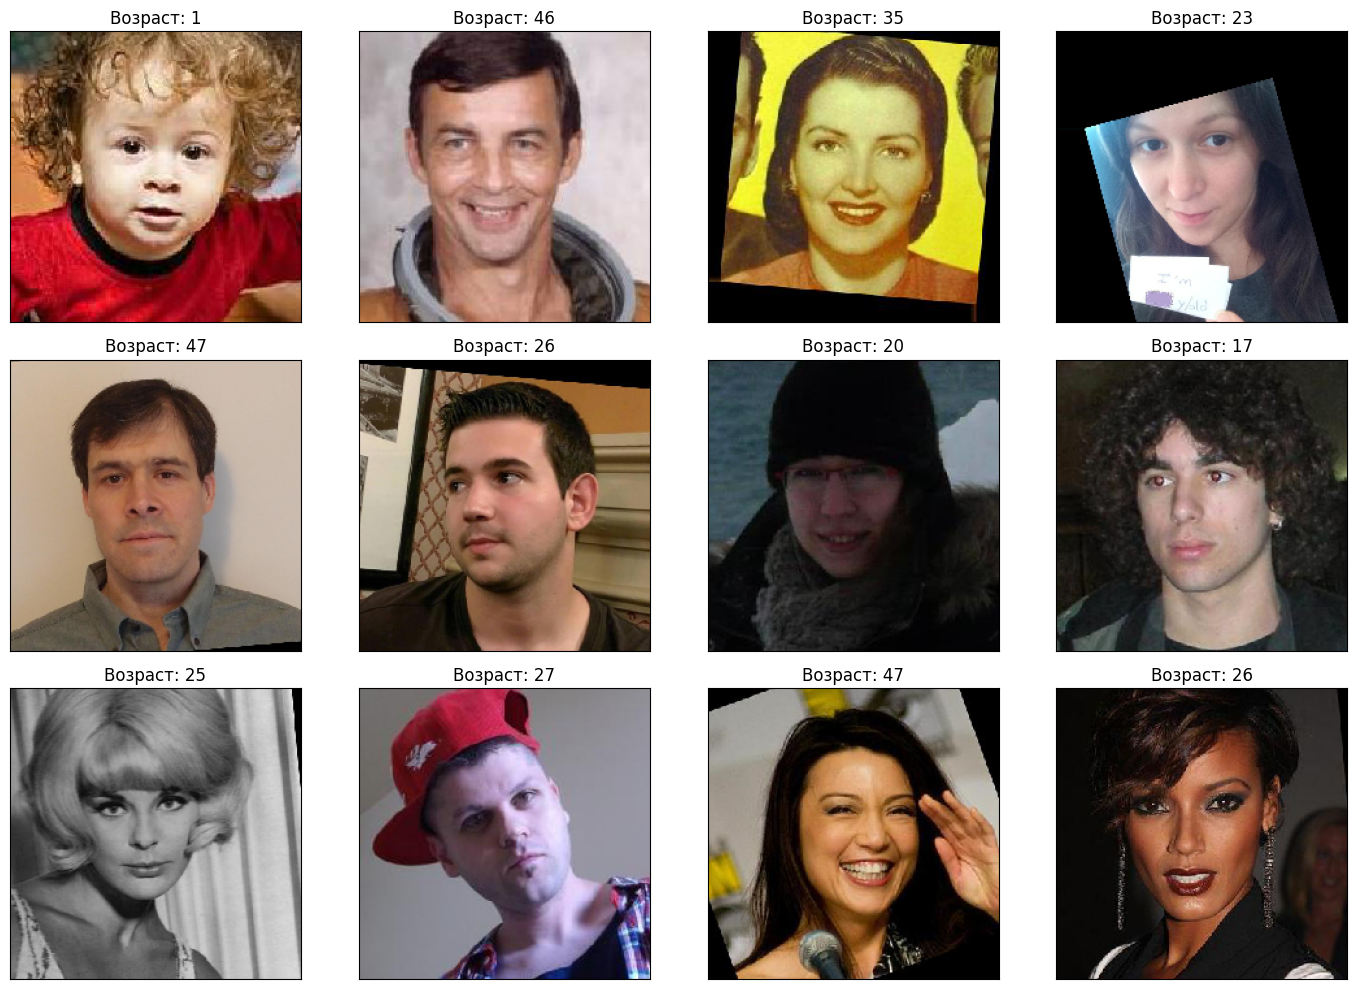

In [10]:
# получение одного батча
features, target = next(datagen_flow)

# график с изображениями из батча
fig = plt.figure(figsize=(15,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Возраст: ' + str(target[i]))

Известно, что для каждого входного изображения сначала была проведена детекция лица, затем выравнивание по фронтальному положению лица и обрезка с отступом в 40% вокруг обнаруженного лица.

Фотографии в датасете приведены к одному размеру, но по содержанию заметно разнятся  - повороты головы, эмоции, очки, чёрно-белые и цветные, обрезанные, есть с детализацией низкого качества.

___
Проведённый анализ данных поможет нам учитывать особенности датасета при построении модели и оценке результатов обучения. Отметим следующие моменты:

- Ограниченный диапазон возрастов 1-100 лет
- Дисбаланс в предоставленных данных: возраста от 15 до 40 имеют большую выборку - 100-300 фотографий, а возраста выше 55 представлены  реже - до 50 фото. Вероятно, модель будет сильнее ошибаться на возрастах с меньшей выборкой.
Для увеличения выборки менее предствавленных возрастов применим аугментацию.

## Моделирование и обучение

Перед нами поставлена задача предсказания возраста человека по фотографии его лица. Рассмотрим её как задачу регрессии, метод обучения с учителем. 

Для работы с изображениями будем использовать свёрточную нейронную сеть на готовой архитектуре ResNet50, обученную на датасете ImageNet, которую дообучим для нашей задачи. 

Чтобы исключить неадекватные предсказания в последнем слое нейронной сети используем функцию активации Relu, которая пропускает только положительные значения, а отрицательные приводит к нулю.

В качестве метрики качества будем использовать среднюю абсолютную ошибку MAE, которая хорошо интерпретируется. По условию задачи её значение на тестовой выборке не должно превышать 8.  

В качестве функции потерь возьмём среднюю квадратичную ошибку MSE.


In [31]:
# функция для динамической загрузки датасета с изображениями - обучающая выборка

def load_train(path):

    # загрузка таблицы
    labels = pd.read_csv(path + 'labels.csv')
    
    # инициализация загрузчика
    train_datagen = ImageDataGenerator(rescale=1/255,
                                       validation_split=0.25,
                                       horizontal_flip=True)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=random_state)
 
    return train_datagen_flow


# функция для динамической загрузки датасета с изображениями - тестовая выборка
def load_test(path):

    # загрузка таблицы
    labels = pd.read_csv(path + 'labels.csv')    
    
    # инициализация загрузчика
    test_datagen = ImageDataGenerator(rescale=1/255,
                                   validation_split=0.25)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=random_state,
        shuffle=False)
 
    return test_datagen_flow



# функция для создания модели на архитектуре ResNet50
def create_model(input_shape, model_weights=None):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights=model_weights,
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


# функция для обучения
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              batch_size=batch_size,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)

    return model

In [34]:
# загружаем выборки
train_datagen_flow = load_train(path)
test_datagen_flow = load_test(path)
# создаём модель
input_shape = (224, 224, 3)
model = create_model(input_shape, 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5') # веса обуч. Imagenet
# обучаем модель с 20 эпохами
train_model(model, train_datagen_flow, test_datagen_flow, epochs=10)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


```Python
Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 52s - loss: 216.5897 - mae: 10.6228 - val_loss: 602.4648 - val_mae: 19.6332
Epoch 2/20
178/178 - 41s - loss: 72.4358 - mae: 6.4608 - val_loss: 502.2975 - val_mae: 17.2630
Epoch 3/20
178/178 - 41s - loss: 46.9400 - mae: 5.2284 - val_loss: 399.6438 - val_mae: 15.1385
Epoch 4/20
178/178 - 40s - loss: 33.6052 - mae: 4.3975 - val_loss: 137.7051 - val_mae: 8.6006
Epoch 5/20
178/178 - 40s - loss: 24.4183 - mae: 3.7752 - val_loss: 78.8149 - val_mae: 6.6608
Epoch 6/20
178/178 - 40s - loss: 20.6742 - mae: 3.4576 - val_loss: 71.0269 - val_mae: 6.3336
Epoch 7/20
178/178 - 40s - loss: 15.1091 - mae: 2.9540 - val_loss: 73.3552 - val_mae: 6.3455
Epoch 8/20
178/178 - 41s - loss: 12.8588 - mae: 2.7412 - val_loss: 65.7911 - val_mae: 6.0843
Epoch 9/20
178/178 - 40s - loss: 10.9662 - mae: 2.4935 - val_loss: 63.2343 - val_mae: 5.9313
Epoch 10/20
178/178 - 42s - loss: 8.9502 - mae: 2.2642 - val_loss: 64.4518 - val_mae: 6.1141
Epoch 11/20
178/178 - 43s - loss: 8.4169 - mae: 2.1940 - val_loss: 61.0959 - val_mae: 5.8554
Epoch 12/20
178/178 - 42s - loss: 8.0784 - mae: 2.1263 - val_loss: 62.6975 - val_mae: 5.8907
Epoch 13/20
178/178 - 43s - loss: 7.6973 - mae: 2.0520 - val_loss: 66.3725 - val_mae: 6.0805
Epoch 14/20
178/178 - 42s - loss: 7.8022 - mae: 2.0904 - val_loss: 61.8442 - val_mae: 5.8629
Epoch 15/20
178/178 - 38s - loss: 7.7016 - mae: 2.0650 - val_loss: 66.9538 - val_mae: 5.9818
Epoch 16/20
178/178 - 38s - loss: 7.8393 - mae: 2.1159 - val_loss: 76.0355 - val_mae: 6.4648
Epoch 17/20
178/178 - 38s - loss: 7.9584 - mae: 2.1030 - val_loss: 61.1167 - val_mae: 5.8776
Epoch 18/20
178/178 - 38s - loss: 7.1431 - mae: 2.0237 - val_loss: 62.2117 - val_mae: 5.8647
Epoch 19/20
178/178 - 38s - loss: 7.2606 - mae: 2.0264 - val_loss: 65.6040 - val_mae: 6.1816
Epoch 20/20
178/178 - 38s - loss: 7.1738 - mae: 2.0060 - val_loss: 61.9576 - val_mae: 5.8547
```

Test MAE: 5.8547

По результатам обучения видно, что после 9-ой эпохи метрика на валидационной выборке заметно не уменьшаетс и начинает изменяться в разные стороны. Для итоговой модели оставим 10 эпох.

In [ ]:
# обучаем модель с 10 эпохами
train_model(model, train_datagen_flow, test_datagen_flow, epochs=10)

```Python
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 60s - loss: 253.1498 - mae: 11.2819 - val_loss: 466.9352 - val_mae: 16.4586
Epoch 2/10
178/178 - 48s - loss: 77.2627 - mae: 6.6186 - val_loss: 448.1334 - val_mae: 15.9238
Epoch 3/10
178/178 - 54s - loss: 45.4739 - mae: 5.1292 - val_loss: 310.1686 - val_mae: 12.8763
Epoch 4/10
178/178 - 65s - loss: 33.2374 - mae: 4.3789 - val_loss: 120.8443 - val_mae: 8.2636
Epoch 5/10
178/178 - 52s - loss: 24.6876 - mae: 3.7784 - val_loss: 82.3333 - val_mae: 7.0189
Epoch 6/10
178/178 - 65s - loss: 19.5896 - mae: 3.3279 - val_loss: 77.4852 - val_mae: 6.7888
Epoch 7/10
178/178 - 54s - loss: 15.3310 - mae: 2.9555 - val_loss: 70.4612 - val_mae: 6.1798
Epoch 8/10
178/178 - 58s - loss: 11.0018 - mae: 2.4933 - val_loss: 72.9635 - val_mae: 6.4194
Epoch 9/10
178/178 - 47s - loss: 9.1688 - mae: 2.2914 - val_loss: 66.6143 - val_mae: 6.0505
Epoch 10/10
178/178 - 51s - loss: 9.0164 - mae: 2.2606 - val_loss: 67.5691 - val_mae: 6.0124
```

In [ ]:
# сохраняем веса модели в файл
model.save_weights("model_weights.h5")

Test MAE: 6.0124

Мы построили свёрточную нейронную сеть на основе архитектуры ResNet50, обученной на датасете Imagenet, дообучили её для задачи предсказания возраста на нашем датасете. 

Применена агментация ко тренировочной выборке, чтобы расширить датасет и компенсировать выборку малопредставленных возрастов.

Достигнута метрика качества на тестовой выборке MAE = 6.01.



Что мы заметили при моделировании:
- добавлении вариаций аугментации требует больше эпох для обучения до того же уровня качества, +3 аугментации увеличивает время обучения в 2 раза
- при увеличении количества эпох после 8-10 эпохи не происходит прироста качества

## Анализ обученной модели

Значения функции потерь и метрики после каждой эпохи:
- на обучающей выборке выше, чем на валидационной - признак переобучение модели, но
- на валидационной выборке последовательно уменьшается - улучшение обобщающей способности модели всё же происходит.

Достанем предсказания и проанализируем ошибку

In [35]:
# для анализа создаём модель, загружаем в неё веса обученной в колабе модели
input_shape = (224, 224, 3)
model = create_model(input_shape)
model.load_weights("model_weights.h5")
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 200)               409800    
                                                                 
 dense_9 (Dense)             (None, 1)                 201       
                                                                 
Total params: 23,997,713
Trainable params: 23,944,593
Non-trainable params: 53,120
_________________________________________________________________


In [74]:
# расссчитаем предсказания 
# predictions = model.predict(test_datagen_flow)
# создадим таблицу с предсказаниями на тестовой выборке
results = pd.DataFrame(predictions.astype('int'), columns=['pred'])
# добавим в таблицу реальный возраст
results['real'] = test_datagen_flow.labels
# # рассчитаем ошибку 
results['error'] = results['pred'] - results['real'] # если предсказал старше - то ошибка выше нуля
# # рассчитаем абсолютную ошибку 
results['absolute_error'] = abs(results['pred'] - results['real'])
# dummy модель 
results['dummy_error'] = results['real'] - round(results['real'].median())

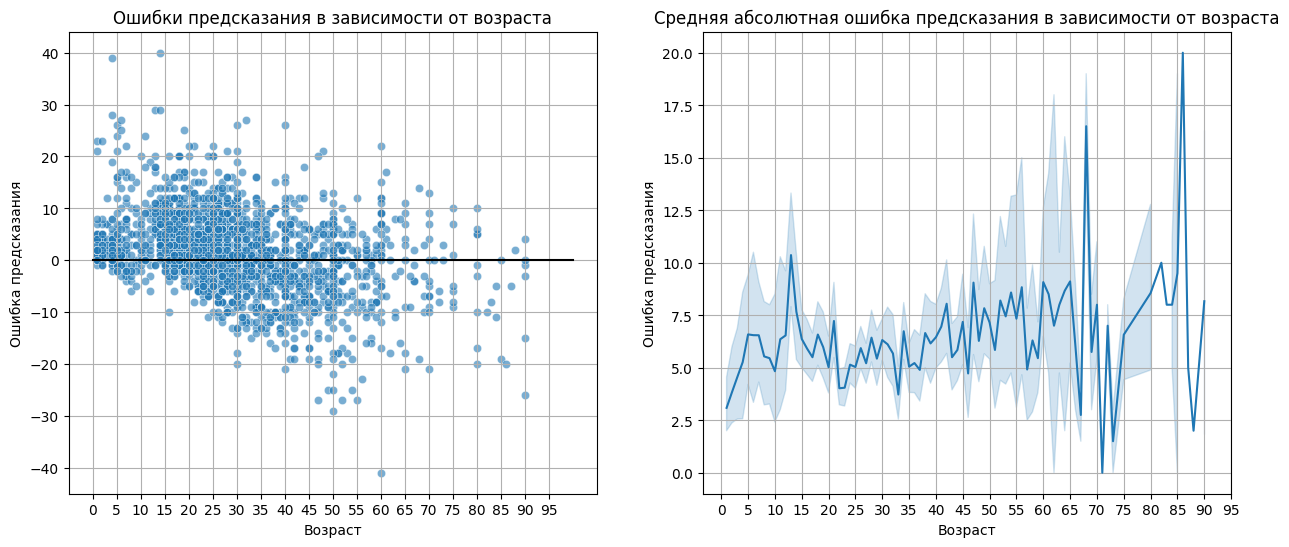

In [105]:
# # график ошибки в зависимости от возраста
fig, axs = plt.subplots(1, 2, figsize=(15,6)) 
# линия для 0
sns.lineplot(x=[0, 100], y=[0, 0], linestyle='-', color='black', ax=axs[0])

sns.scatterplot(data=results, x='real', y='error', alpha=0.6, ax=axs[0])
axs[0].set_title('Ошибки предсказания в зависимости от возраста')
# для абсолютной ошибки среднее по возрасту
sns.lineplot(data=results, x='real', y='absolute_error', ax=axs[1])

plt.title('Средняя абсолютная ошибка предсказания в зависимости от возраста')
for i in [0, 1]:
    axs[i].set_xlabel('Возраст')
    axs[i].set_ylabel('Ошибка предсказания')
    axs[i].set_xticks(range(0, 100, 5))
    axs[i].grid(True)
plt.show()

In [106]:
results[['real', 'pred', 'absolute_error']].describe().T

,count,mean,std,min,25%,50%,75%,max
real,1897.0,29.616236,16.764323,1.0,18.0,27.0,40.0,90.0
pred,1897.0,31.102267,15.655073,0.0,22.0,29.0,39.0,94.0
absolute_error,1897.0,6.014233,5.291733,0.0,2.0,5.0,8.0,41.0


In [101]:
# проверка на адекватность - сравнение с моделью всегда предсказывающую медиану возрастов
print('Test pred MAE: {:.2f}'.format((results['absolute_error']).sum()/len(results['absolute_error'])))
print('Test dummy MAE: {:.2f}'.format((results['dummy_error']).abs().sum()/len(results['dummy_error'])))

Test pred MAE: 6.01
Test dummy MAE: 12.79


- Абсолютная ошибка предсказания модели в среднем составляет 6 лет.Такой результат приемлем в случае использования предсказаний для анализа и рекомендаций по возрастным группам и только как дополнительный (не основной) инструмент для контроля добросовестности кассиров.
- Закономерно для модели - предсказывать больше в диапазоне до 20 и меньше после 35.
- Абсолютная ошибка более высокая для пожилых возрастов (65+)

___

## Выводы
Перед нами была поставлена задача предсказания возраста покупателя по его фотографии с целью внедрения рекомендательной системы и контроля добросовестности кассиров при продаже алкоголя.

Для анализа и обучения предоставлен датасет ChaLearn Looking at People с фотографиями лиц людей и размеченным реальным возрастом.   
В датасете выборка для каждого возраста неравномерная: по 100-300 фотографий для возрастов 15-40 и менее 100 у остальных, для возрастов выше 55 - меньше 50.
 
Мы построили свёрточную нейронную сеть на основе архитектуры ResNet50, предобученной на датасете Imagenet, дообучили её для задачи предсказания возраста на нашем датасете с использованием аугментации.  

Получена модель со средней абсолютной ошибкой на валидационной выборке 6 ед., что соответствует поставленному условию MAE < 8.  
Модель с таким результатом будет пригодна для реализации рекомендательной системы по возрастным группам, но не рекомендуется как основной инструмент для контроля добросовестности кассиров.
